In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv('train_cleaned.csv')
test_df = pd.read_csv('test_cleaned.csv')
val_df = pd.read_csv('val_cleaned.csv')

In [ ]:
custom_map = {"sad": 0, "happy": 1, "angry": 2, "calm": 3}

In [ ]:
train_df['mood_num'] = train_df['mood'].map(custom_map)
test_df['mood_num'] = test_df['mood'].map(custom_map)
val_df['mood_num'] = val_df['mood'].map(custom_map)

In [ ]:
print("Train class counts:\n", train_df['mood'].value_counts(normalize=True))
print("\nTest class counts:\n", test_df['mood'].value_counts(normalize=True))
print("\nValidation class counts:\n", val_df['mood'].value_counts(normalize=True))

Train class counts:
 mood
calm     0.450465
happy    0.352575
sad      0.098515
angry    0.098445
Name: proportion, dtype: float64

Test class counts:
 mood
calm     0.454160
happy    0.342188
angry    0.104593
sad      0.099059
Name: proportion, dtype: float64

Validation class counts:
 mood
calm     0.444219
happy    0.360686
sad      0.100498
angry    0.094597
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Function to undersample a dataset
def balance_dataset(df, target_col='mood'):
    # Find the minority class count
    min_count = df[target_col].value_counts().min()

    # List to store resampled dataframes
    balanced_dfs = []

    # Resample each class to min_count
    for mood in df[target_col].unique():
        mood_df = df[df[target_col] == mood]
        mood_resampled = resample(mood_df,
                                  replace=False,       # undersample
                                  n_samples=min_count,
                                  random_state=42)
        balanced_dfs.append(mood_resampled)

    # Combine all classes
    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

# Apply to datasets
train_balanced = balance_dataset(train_df)
test_balanced = balance_dataset(test_df)
val_balanced = balance_dataset(val_df)

# Save the balanced datasets
train_balanced.to_csv('train_balanced.csv', index=False)
test_balanced.to_csv('test_balanced.csv', index=False)
val_balanced.to_csv('val_balanced.csv', index=False)

# Check new class distribution
print("Balanced Train class counts:\n", train_balanced['mood'].value_counts(normalize=True))
print("\nBalanced Test class counts:\n", test_balanced['mood'].value_counts(normalize=True))
print("\nBalanced Validation class counts:\n", val_balanced['mood'].value_counts(normalize=True))


Balanced Train class counts:
 mood
happy    0.25
sad      0.25
calm     0.25
angry    0.25
Name: proportion, dtype: float64

Balanced Test class counts:
 mood
sad      0.25
angry    0.25
calm     0.25
happy    0.25
Name: proportion, dtype: float64

Balanced Validation class counts:
 mood
calm     0.25
angry    0.25
sad      0.25
happy    0.25
Name: proportion, dtype: float64


In [ ]:
# Function to print dataset sizes
def print_dataset_sizes(df, name="Dataset"):
    print(f"\n{name} size: {len(df)} rows")
    print(df['mood'].value_counts())
    print(df['mood'].value_counts(normalize=True))

# Check original dataset sizes
print_dataset_sizes(train_df, "Original Train")
print_dataset_sizes(test_df, "Original Test")
print_dataset_sizes(val_df, "Original Validation")

# Check balanced dataset sizes
print_dataset_sizes(train_balanced, "Balanced Train")
print_dataset_sizes(test_balanced, "Balanced Test")
print_dataset_sizes(val_balanced, "Balanced Validation")



Original Train size: 43222 rows
mood
calm     19470
happy    15239
sad       4258
angry     4255
Name: count, dtype: int64
mood
calm     0.450465
happy    0.352575
sad      0.098515
angry    0.098445
Name: proportion, dtype: float64

Original Test size: 5421 rows
mood
calm     2462
happy    1855
angry     567
sad       537
Name: count, dtype: int64
mood
calm     0.454160
happy    0.342188
angry    0.104593
sad      0.099059
Name: proportion, dtype: float64

Original Validation size: 5423 rows
mood
calm     2409
happy    1956
sad       545
angry     513
Name: count, dtype: int64
mood
calm     0.444219
happy    0.360686
sad      0.100498
angry    0.094597
Name: proportion, dtype: float64

Balanced Train size: 17020 rows
mood
happy    4255
sad      4255
calm     4255
angry    4255
Name: count, dtype: int64
mood
happy    0.25
sad      0.25
calm     0.25
angry    0.25
Name: proportion, dtype: float64

Balanced Test size: 2148 rows
mood
sad      537
angry    537
calm     537
happy    537
Na

In [1]:
import pandas as pd
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
train_df = pd.read_csv('train_balanced.csv')
val_df = pd.read_csv('val_balanced.csv')
test_df = pd.read_csv('test_balanced.csv')

In [3]:
train_df.rename(columns={'mood_num': 'label'}, inplace=True)
val_df.rename(columns={'mood_num': 'label'}, inplace=True)
test_df.rename(columns={'mood_num': 'label'}, inplace=True)

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=64):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
train_dataset = EmotionDataset(train_df, tokenizer)
val_dataset = EmotionDataset(val_df, tokenizer)
test_dataset = EmotionDataset(test_df, tokenizer)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

print("✅ Balanced datasets loaded and tokenized!")
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

✅ Balanced datasets loaded and tokenized!
Train batches: 2128, Validation batches: 257


In [8]:
import torch
from torch import nn
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4  # sad, happy, angry, calm
)
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
optimizer = AdamW(model.parameters(), lr=5e-6, eps=1e-8, weight_decay=0.05)
epochs = 12
total_steps = len(train_loader) * epochs

num_warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

In [12]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
    return total_loss / len(data_loader)

In [13]:
def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [14]:
import torch

# Initialize trackers
train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
patience = 3  # Number of epochs to wait before stopping
epochs_without_improvement = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # ---- Training Phase ----
    train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)

    # ---- Validation Phase ----
    val_loss, val_acc = eval_epoch(model, val_loader, device)

    # ---- Logging ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # ---- Check for Improvement ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0

        # Save the best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': best_val_loss
        }, "best_bert_emotion_model.pth")

        print("✅ New best model found and saved!")
    else:
        epochs_without_improvement += 1
        print(f"🛑 No validation loss improvement for {epochs_without_improvement} epochs.")

        # ---- Early Stopping ----
        if epochs_without_improvement >= patience:
            print("⏹️ Early stopping triggered.")
            break

print("✅ Training complete!")

# ---- Load the Best Model for Final Evaluation ----
checkpoint = torch.load("best_bert_emotion_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Best model loaded (Epoch {checkpoint['epoch']}, Val Loss: {checkpoint['val_loss']:.4f})")



Epoch 1/12


Train Loss: 1.2700 | Val Loss: 0.9141 | Val Acc: 0.6413
✅ New best model found and saved!

Epoch 2/12


Train Loss: 0.8485 | Val Loss: 0.8069 | Val Acc: 0.6813
✅ New best model found and saved!

Epoch 3/12


Train Loss: 0.7079 | Val Loss: 0.8058 | Val Acc: 0.6842
✅ New best model found and saved!

Epoch 4/12


Train Loss: 0.5938 | Val Loss: 0.8681 | Val Acc: 0.6813
🛑 No validation loss improvement for 1 epochs.

Epoch 5/12


Train Loss: 0.4895 | Val Loss: 0.9364 | Val Acc: 0.6706
🛑 No validation loss improvement for 2 epochs.

Epoch 6/12


Train Loss: 0.3996 | Val Loss: 1.0157 | Val Acc: 0.6711
🛑 No validation loss improvement for 3 epochs.
⏹️ Early stopping triggered.
✅ Training complete!
✅ Best model loaded (Epoch 3, Val Loss: 0.8058)


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import shutil

# Move the model file to your Drive folder
shutil.move("best_bert_emotion_model.pth", "/content/drive/MyDrive/best_bert_emotion_model.pth")

print("✅ Model saved to your Google Drive at: /content/drive/MyDrive/best_bert_emotion_model.pth")


✅ Model saved to your Google Drive at: /content/drive/MyDrive/best_bert_emotion_model.pth


In [17]:
tokenizer.save_pretrained("/content/drive/MyDrive/bert_emotion_tokenizer")
print("✅ Tokenizer saved to Drive at: /content/drive/MyDrive/bert_emotion_tokenizer")

✅ Tokenizer saved to Drive at: /content/drive/MyDrive/bert_emotion_tokenizer


✅ Best model loaded from Drive (Epoch 3, Val Loss: 0.8058)


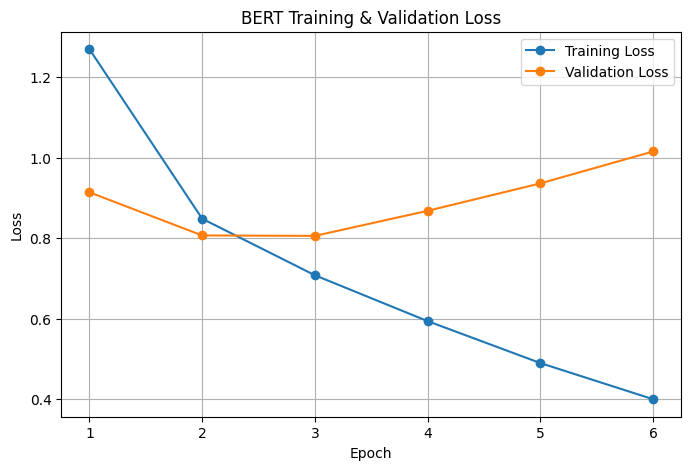

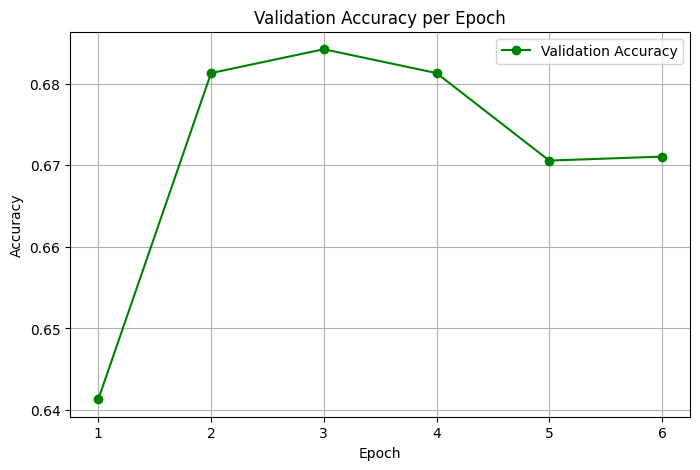

In [19]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, accuracy_score

# ==== 1️⃣ Load best model from Drive ====
model_path = "/content/drive/MyDrive/best_bert_emotion_model.pth"

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"✅ Best model loaded from Drive (Epoch {checkpoint['epoch']}, Val Loss: {checkpoint['val_loss']:.4f})")

# ==== 2️⃣ Plot Training & Validation Loss ====
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BERT Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ==== 3️⃣ Plot Validation Accuracy per Epoch ====
plt.figure(figsize=(8,5))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ==== 5️⃣ Compute Metrics ====
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"\n✅ Final Validation Accuracy: {accuracy:.4f}")
print(f"✅ Weighted F1-score: {f1:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["sad", "happy", "angry", "calm"]))



✅ Final Validation Accuracy: 0.6842
✅ Weighted F1-score: 0.6846

Detailed Classification Report:
              precision    recall  f1-score   support

         sad       0.68      0.66      0.67       513
       happy       0.79      0.75      0.77       513
       angry       0.68      0.72      0.70       513
        calm       0.60      0.61      0.60       513

    accuracy                           0.68      2052
   macro avg       0.69      0.68      0.68      2052
weighted avg       0.69      0.68      0.68      2052



In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Re-create the model with the same architecture
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4
)

# Move the model to the GPU before loading the state dictionary
model.to(device)

# Load the saved model's state dictionary
model_path = '/content/drive/MyDrive/best_bert_emotion_model.pth'
# Load the entire checkpoint dictionary
checkpoint = torch.load(model_path, map_location=device)

# Extract the model's state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# Run the evaluation loop
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        # Move each batch of data to the GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device) # Make sure this is still here

        # The model and inputs are now on the same device
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Get accuracy and a detailed classification report
# ... (rest of your code)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
import numpy as np

In [21]:
# Get accuracy and a detailed classification report
test_accuracy = np.mean(np.array(all_labels) == np.array(all_preds))

# Assuming your labels are mapped as: 0: sad, 1: happy, 2: angry, 3: calm
class_names = ['sad', 'happy', 'angry', 'calm']

print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Test Accuracy: 0.6839

Classification Report:
              precision    recall  f1-score   support

         sad       0.64      0.65      0.65       537
       happy       0.79      0.77      0.78       537
       angry       0.68      0.71      0.69       537
        calm       0.62      0.61      0.62       537

    accuracy                           0.68      2148
   macro avg       0.68      0.68      0.68      2148
weighted avg       0.68      0.68      0.68      2148

